<a href="https://colab.research.google.com/github/mrudulmamtani/vroom-vroom/blob/main/aerodynamic_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
import requests
from io import StringIO
import scipy.io as sio

In [9]:
# For this example, we'll use the Mendeley dataset on velocity and pressure data
# In a real application, you would download the dataset from the source
# URL: https://data.mendeley.com/datasets/dk5zrpmg2z

# Since we can't directly access the dataset, let's create a sample dataset
# based on Bernoulli's equation: P + (1/2)ρv² + ρgh = constant
# This is a simplified version for demonstration
def generate_sample_data(n_samples=1000):
    np.random.seed(42)

    # Constants
    rho = 1.225  # air density in kg/m³
    g = 9.81     # gravity in m/s²

    # Generate random heights, pressures, and velocities
    height = np.random.uniform(0, 100, n_samples)
    velocity = np.random.uniform(0, 50, n_samples)

    # Calculate pressure based on Bernoulli's equation with some noise
    constant = np.random.uniform(1000, 2000)
    pressure = constant - 0.5 * rho * velocity**2 - rho * g * height
    pressure += np.random.normal(0, 50, n_samples)  # Add some noise

    # Calculate optimal speed (target variable) with a complex relationship
    # In a real scenario, this would be your measured optimal speed
    optimal_speed = 0.8 * velocity + 0.01 * pressure + 0.2 * height + np.random.normal(0, 2, n_samples)

    # Create a DataFrame
    df = pd.DataFrame({
        'pressure': pressure,
        'velocity': velocity,
        'height': height,
        'optimal_speed': optimal_speed
    })

    return df

# Generate sample data
df = generate_sample_data(1000)
print(df.head())


     pressure   velocity     height  optimal_speed
0  776.880211   9.256646  37.454012      18.493290
1 -341.508846  27.095047  95.071431      36.901496
2 -826.829032  43.647292  73.199394      40.811596
3 -324.843409  36.611244  59.865848      40.874042
4   62.881910  40.328057  15.601864      36.679094


In [10]:

# Split features and target
X = df[['pressure', 'velocity', 'height']]
y = df['optimal_speed']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [11]:
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train an XGBoost model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Define hyperparameter grid for tuning
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1]
}


In [12]:
# Perform grid search with cross-validation
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train_scaled, y_train)

# Get the best model
best_model = grid_search.best_estimator_
print(f"Best parameters: {grid_search.best_params_}")

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}


In [13]:
# Make predictions on the test set
y_pred = best_model.predict(X_test_scaled)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.4f}")
print(f"R² Score: {r2:.4f}")

Mean Squared Error: 4.2694
R² Score: 0.9347


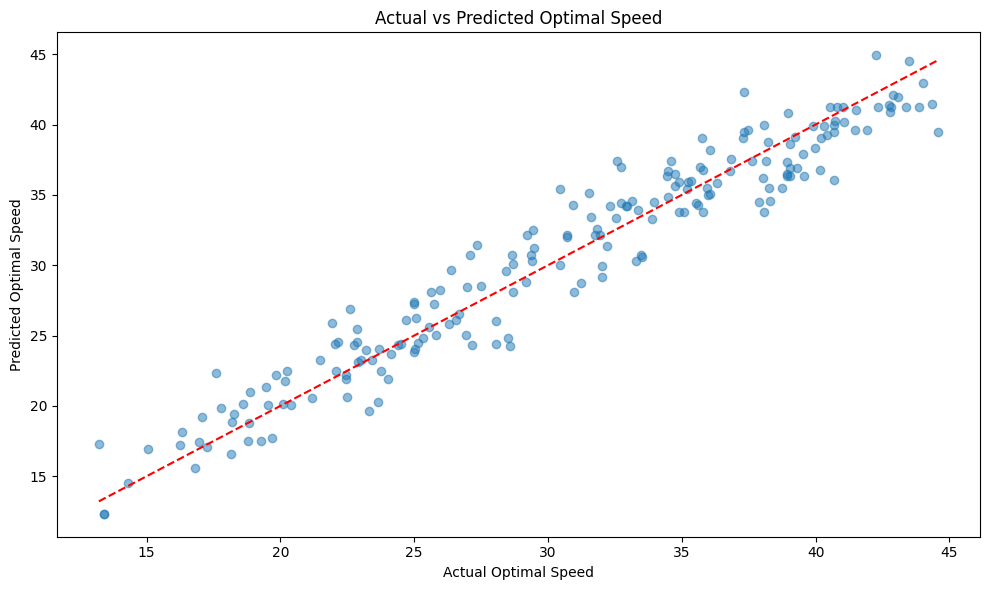

In [14]:
# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Optimal Speed')
plt.ylabel('Predicted Optimal Speed')
plt.title('Actual vs Predicted Optimal Speed')
plt.tight_layout()
plt.show()

<Figure size 1000x600 with 0 Axes>

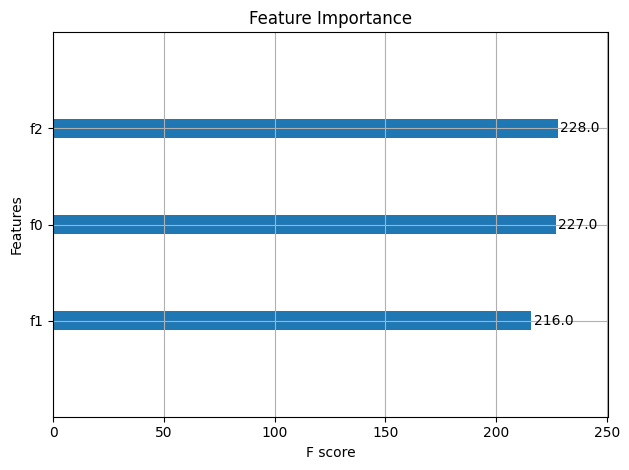

In [15]:
# Feature importance
plt.figure(figsize=(10, 6))
xgb.plot_importance(best_model)
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

In [16]:
# Function to predict optimal speed for new data
def predict_optimal_speed(pressure, velocity, height):
    # Create a DataFrame with the new data
    new_data = pd.DataFrame({
        'pressure': [pressure],
        'velocity': [velocity],
        'height': [height]
    })

    # Scale the new data
    new_data_scaled = scaler.transform(new_data)

    # Make prediction
    prediction = best_model.predict(new_data_scaled)[0]

    return prediction

In [17]:
# Example usage
pressure = 1000  # Pa
velocity = 25    # m/s
height = 50      # m

predicted_speed = predict_optimal_speed(pressure, velocity, height)
print(f"Predicted optimal speed for pressure={pressure} Pa, velocity={velocity} m/s, height={height} m: {predicted_speed:.2f} m/s")


Predicted optimal speed for pressure=1000 Pa, velocity=25 m/s, height=50 m: 32.02 m/s
